# Wright-Fisher model of mutation and random genetic drift

A Wright-Fisher model has a fixed population size *N* and discrete non-overlapping generations. Each generation, each individual has a random number of offspring whose mean is proportional to the individual's fitness. Each generation, mutation may occur.

![](files/wright-fisher.png)

## Setup

In [1]:
import numpy as np

## Make population dynamic model

### Setup a population of sequences

Store this as a lightweight Dictionary that maps a string to a count. All the sequences together will have count *N*.

In [2]:
pop_size = 100

In [3]:
seq_length = 10

In [4]:
alphabet = ['A', 'T', 'G', 'C']

In [5]:
pop = {}

In [6]:
pop["AAAAAAAAAA"] = 40

In [7]:
pop["AAATAAAAAA"] = 30

In [8]:
pop["AATTTAAAAA"] = 30

In [9]:
pop["AAATAAAAAA"]

30

### Add mutation

Mutations occur each generation in each individual in every basepair.

In [10]:
mutation_rate = 0.002 # per gen per individual per site

Walk through population and mutate basepairs. Use Poisson splitting to speed this up. Poisson split works like so:
 * Scenario A: take each element and check for each if event occurs. For example, 100 elements, each with 1% chance. This requires 100 random numbers.
 * Scenario B: Draw a Poisson random number for the number of events that occur and distribute them randomly. In the above example, this will most likely involve 1 random number draw to see how many events and then a few more draws to see which elements are hit.

Need to get random number of total mutations

In [11]:
def get_mutation_count():
    mean = mutation_rate * pop_size * seq_length
    return np.random.poisson(mean)

Above we use Numpy's [Poisson random number](http://docs.scipy.org/doc/numpy/reference/generated/numpy.random.poisson.html).

In [12]:
get_mutation_count()

3

Need to get random haplotype from the population.

In [13]:
pop.keys()

['AAAAAAAAAA', 'AAATAAAAAA', 'AATTTAAAAA']

In [14]:
[x/float(pop_size) for x in pop.values()]

[0.4, 0.3, 0.3]

In [15]:
def get_random_haplotype():
    haplotypes = pop.keys() 
    frequencies = [x/float(pop_size) for x in pop.values()]
    return np.random.choice(haplotypes, p=frequencies)

Above we use Numpy's [weighted random choice](http://docs.scipy.org/doc/numpy/reference/generated/numpy.random.choice.html).

In [16]:
hap = get_random_haplotype()

In [17]:
hap

'AAAAAAAAAA'

In [18]:
def get_mutant(haplotype):
    site = np.random.randint(seq_length)
    possible_mutations = list(alphabet)
    possible_mutations.remove(haplotype[site])
    mutation = np.random.choice(possible_mutations)
    new_haplotype = haplotype[:site] + mutation + haplotype[site+1:]
    return new_haplotype

In [19]:
get_mutant(hap)

'AAAACAAAAA'

In [20]:
def mutation_event():
    haplotype = get_random_haplotype()
    if pop[haplotype] > 1:
        pop[haplotype] -= 1
        new_haplotype = get_mutant(haplotype)
        if new_haplotype in pop:
            pop[new_haplotype] += 1
        else:
            pop[new_haplotype] = 1

In [21]:
mutation_event()

In [22]:
pop

{'AAAAAAAAAA': 40, 'AAATAAAAAA': 30, 'AATTTAAAAA': 29, 'TATTTAAAAA': 1}

In [23]:
def mutation_step():
    mutation_count = get_mutation_count()
    for i in range(mutation_count):
        mutation_event()

In [24]:
mutation_step()

In [25]:
pop

{'AAAAAAAAAA': 40,
 'AAATAAAAAA': 27,
 'AAATAAGAAA': 1,
 'AAATATAAAA': 1,
 'AATTTAAAAA': 29,
 'ACATAAAAAA': 1,
 'TATTTAAAAA': 1}

### Add genetic drift

In [26]:
def get_offspring_counts():
    haplotypes = pop.keys() 
    frequencies = [x/float(pop_size) for x in pop.values()]
    return list(np.random.multinomial(pop_size, frequencies))

In [27]:
get_offspring_counts()

[46, 0, 1, 25, 3, 1, 24]

In [28]:
def offspring_step():
    counts = get_offspring_counts()
    for (haplotype, count) in zip(pop.keys(), counts):
        if (count > 0):
            pop[haplotype] = count
        else:
            del pop[haplotype]

In [29]:
offspring_step()

In [30]:
pop

{'AAAAAAAAAA': 38,
 'AAATAAAAAA': 34,
 'AAATATAAAA': 1,
 'AATTTAAAAA': 24,
 'ACATAAAAAA': 2,
 'TATTTAAAAA': 1}

### Combine and iterate

In [31]:
generations = 10

In [32]:
def time_step():
    mutation_step()
    offspring_step()

In [33]:
def simulate():
    for i in range(generations):
        time_step()

In [34]:
simulate()

In [35]:
pop

{'AAAAAAAAAA': 39,
 'AAATAAAAAA': 27,
 'AAGTAAAAAA': 2,
 'AATTTAAAAA': 20,
 'TATTTAAAAA': 12}

### Record

In [36]:
pop = {"AAAAAAAAAA": pop_size}

In [37]:
history = []

In [38]:
def simulate():
    clone_pop = dict(pop)
    history.append(clone_pop)
    for i in range(generations):
        time_step()
        clone_pop = dict(pop)
        history.append(clone_pop)

In [39]:
simulate()

In [40]:
pop

{'AAAAAAAAAA': 96, 'AAAAAAAAGA': 1, 'AAAAAGAAAA': 1, 'AAAGAAAAAA': 2}

In [41]:
history

[{'AAAAAAAAAA': 100},
 {'AAAAAAAAAA': 100},
 {'AAAAAAAAAA': 96, 'AAAACAAAAA': 1, 'AACAAAAAAA': 2, 'ACAAAAAAAA': 1},
 {'AAAAAAAAAA': 97, 'AACAAAAAAA': 3},
 {'AAAAAAAAAA': 93,
  'AAAAAAAAAC': 1,
  'AACAAAAAAA': 2,
  'AATAAAAAAA': 1,
  'TAAAAAAAAA': 3},
 {'AAAAAAAAAA': 96, 'AACAAAAAAA': 1, 'TAAAAAAAAA': 3},
 {'AAAAAAAAAA': 98, 'AACAAAAAAA': 1, 'TAAAAAAAAA': 1},
 {'AAAAAAAAAA': 95, 'AAACAAAAAA': 2, 'AACAAAAAAA': 1, 'TAAAAAAAAA': 2},
 {'AAAAAAAAAA': 99, 'TAAAAAAAAA': 1},
 {'AAAAAAAAAA': 98, 'AAAAAAAAGA': 1, 'AAAATAAAAA': 1},
 {'AAAAAAAAAA': 96, 'AAAAAAAAGA': 1, 'AAAAAGAAAA': 1, 'AAAGAAAAAA': 2}]

## Analyze trajectories

### Calculate diversity

Here, diversity in population genetics is usually shorthand for the statistic *&pi;*, which measures pairwise differences between random individuals in the population. *&pi;* is usually measured as substitutions per site.

In [42]:
pop

{'AAAAAAAAAA': 96, 'AAAAAAAAGA': 1, 'AAAAAGAAAA': 1, 'AAAGAAAAAA': 2}

In [43]:
def get_divergence(seq_a, seq_b):
    diffs = 0
    length = len(seq_a)
    assert len(seq_a) == len(seq_b)
    for chr_a, chr_b in zip(seq_a, seq_b):
        if chr_a != chr_b:
            diffs += 1
    return diffs / float(length)

In [44]:
get_divergence("AAAAA", "AAAAB")

0.2

In [45]:
def get_diversity(population):
    haplotypes = population.keys()
    haplotype_count = len(haplotypes)
    diversity = 0
    for i in range(haplotype_count):
        for j in range(haplotype_count):
            haplotype_a = haplotypes[i]
            haplotype_b = haplotypes[j]
            frequency_a = population[haplotype_a] / float(pop_size)
            frequency_b = population[haplotype_b] / float(pop_size)
            frequency_pair = frequency_a * frequency_b
            diversity += frequency_pair * get_divergence(haplotype_a, haplotype_b)
    return diversity

In [46]:
get_diversity(pop)

0.0078799999999999999

In [47]:
def get_diversity_trajectory():
    trajectory = [get_diversity(generation) for generation in history]
    return trajectory

In [48]:
get_diversity_trajectory()

[0.0,
 0.0,
 0.0078799999999999999,
 0.0058199999999999997,
 0.013659999999999999,
 0.0078000000000000005,
 0.00396,
 0.0098200000000000006,
 0.0019800000000000004,
 0.00396,
 0.0078799999999999999]

### Plot diversity

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

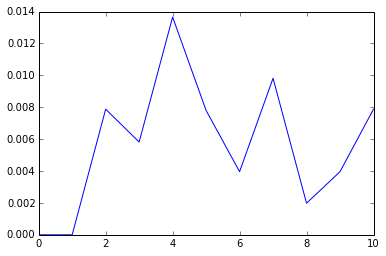

In [50]:
plt.plot(get_diversity_trajectory())

In [51]:
def diversity_plot():
    mpl.rcParams['font.size']=14
    plt.figure(num=None, figsize=(8, 4), dpi=80, facecolor='w', edgecolor='k')
    trajectory = get_diversity_trajectory()
    plt.plot(trajectory)
    plt.ylabel("diversity")
    plt.xlabel("generation")
    plt.show()

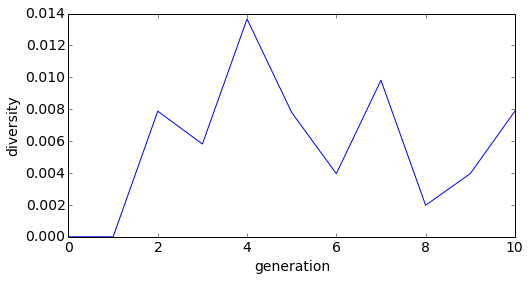

In [52]:
diversity_plot()

### Plot trajectories

In [53]:
def get_frequency(haplotype, generation):
    pop_at_generation = history[generation]
    if haplotype in pop_at_generation:
        return pop_at_generation[haplotype]/float(pop_size)
    else:
        return 0

In [54]:
get_frequency("AAAAAAAAAA", 4)

0.93000000000000005

In [55]:
def get_trajectory(haplotype):
    trajectory = [get_frequency(haplotype, gen) for gen in range(generations)]
    return trajectory

In [56]:
get_trajectory("AAAAAAAAAA")

[1.0,
 1.0,
 0.95999999999999996,
 0.96999999999999997,
 0.93000000000000005,
 0.95999999999999996,
 0.97999999999999998,
 0.94999999999999996,
 0.98999999999999999,
 0.97999999999999998]

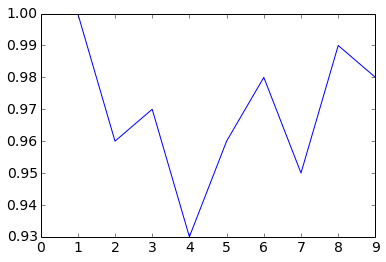

In [57]:
plt.plot(get_trajectory("AAAAAAAAAA"))

In [58]:
def get_all_haplotypes():
    haplotypes = set()   
    for generation in history:
        for haplotype in generation:
            haplotypes.add(haplotype)
    return haplotypes

In [59]:
get_all_haplotypes()

{'AAAAAAAAAA',
 'AAAAAAAAAC',
 'AAAAAAAAGA',
 'AAAAAGAAAA',
 'AAAACAAAAA',
 'AAAATAAAAA',
 'AAACAAAAAA',
 'AAAGAAAAAA',
 'AACAAAAAAA',
 'AATAAAAAAA',
 'ACAAAAAAAA',
 'TAAAAAAAAA'}

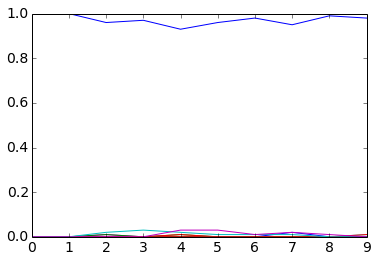

In [60]:
haplotypes = get_all_haplotypes()
for haplotype in haplotypes:
    plt.plot(get_trajectory(haplotype))
plt.show()

In [61]:
colors = ["#781C86", "#571EA2", "#462EB9", "#3F47C9", "#3F63CF", "#447CCD", "#4C90C0", "#56A0AE", "#63AC9A", "#72B485", "#83BA70", "#96BD60", "#AABD52", "#BDBB48", "#CEB541", "#DCAB3C", "#E49938", "#E68133", "#E4632E", "#DF4327", "#DB2122"]

In [62]:
def stacked_trajectory_plot():
    mpl.rcParams['font.size']=18
    plt.figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
    haplotypes = get_all_haplotypes()
    trajectories = [get_trajectory(haplotype) for haplotype in haplotypes]
    plt.stackplot(range(generations), trajectories, colors=colors)
    plt.ylim(0, 1)
    plt.ylabel("frequency")
    plt.xlabel("generation")
    plt.show()

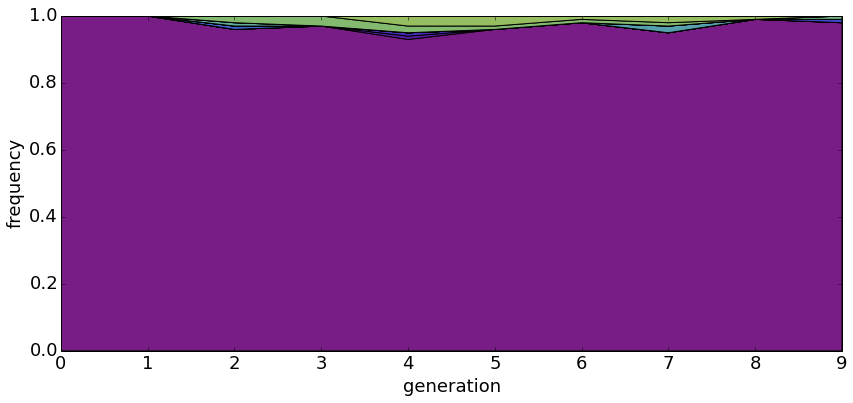

In [63]:
stacked_trajectory_plot()

### Scale up

In [64]:
pop_size = 100
seq_length = 10
generations = 200

In [65]:
def reset():
    base_haplotype = ''.join(["A" for i in range(seq_length)])
    pop.clear()
    del history[:]
    pop[base_haplotype] = pop_size

In [66]:
reset()

In [67]:
pop

{'AAAAAAAAAA': 100}

In [68]:
reset()
simulate()

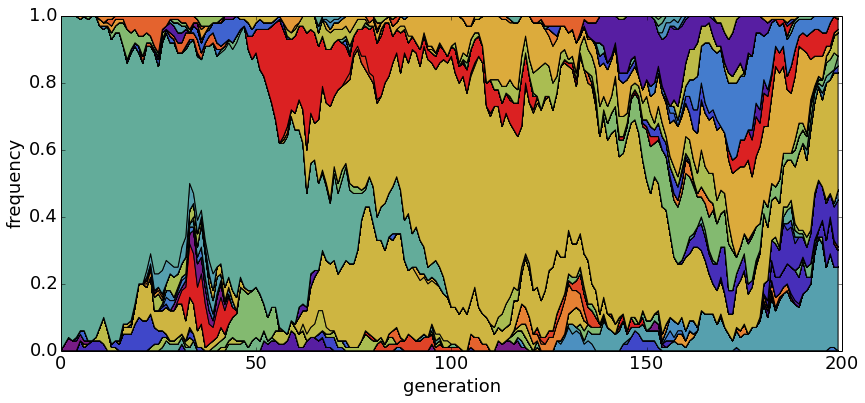

In [69]:
stacked_trajectory_plot()

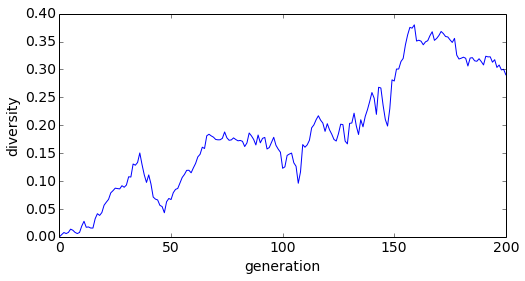

In [70]:
diversity_plot()

# *Exercise: effects of population size and mutation rate on observed haplotype dynamics*

What happens to diversity and observed haplotype dynamics when (A) population size is varied and (B) when mutation rate is varied?